In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('data/clean_housing.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

# Build a Baseline Model
In order to fit a baseline model for use in comparisons with the more complete model I will conduct these steps:
1. Handle Muliticolinearity
2. Standardize Variables
3. Fit and Validate the Baseline Model

## 1. Handle Multicolinearity 

In [3]:
high_corr = ((abs(data.corr())> .8).sum()>1)
high_corr

price              False
bedrooms           False
bathrooms          False
sqft_living         True
floors             False
view               False
grade              False
sqft_above          True
sqft_basement      False
lat                False
long               False
sqft_living15      False
WaterFront         False
month_sold         False
age                 True
yrs_reno            True
Renovated          False
dist_to_Seattle    False
Bellevue           False
Federal Way        False
Kent               False
Renton             False
Seattle            False
rel_size           False
dtype: bool

In [4]:
data[['sqft_living', 'sqft_above', 'age', 'yrs_reno']].corr()

,sqft_living,sqft_above,age,yrs_reno
sqft_living,1.000000,0.839928,-0.366374,-0.376171
sqft_above,0.839928,1.000000,-0.483522,-0.482732
age,-0.366374,-0.483522,1.000000,0.938751
yrs_reno,-0.376171,-0.482732,0.938751,1.000000


To avoid multicolinearity issues I will drop sqft_above, because the information already exists in a combination of sqft_living and sqft_basement. I will also drop yrs_reno, because the data on whether the house has been renovated or not already exists in the renovated column. 

In [5]:
data.drop(['sqft_above', 'yrs_reno'], axis = 1, 
          inplace = True)

## 2. Standardize Variables 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16261 entries, 0 to 16260
Data columns (total 22 columns):
price              16261 non-null float64
bedrooms           16261 non-null int64
bathrooms          16261 non-null float64
sqft_living        16261 non-null int64
floors             16261 non-null float64
view               16261 non-null float64
grade              16261 non-null int64
sqft_basement      16261 non-null int64
lat                16261 non-null float64
long               16261 non-null float64
sqft_living15      16261 non-null int64
WaterFront         16261 non-null int64
month_sold         16261 non-null int64
age                16261 non-null int64
Renovated          16261 non-null int64
dist_to_Seattle    16261 non-null float64
Bellevue           16261 non-null int64
Federal Way        16261 non-null int64
Kent               16261 non-null int64
Renton             16261 non-null int64
Seattle            16261 non-null int64
rel_size           16261 non-null flo

In [7]:
#Separate data into categorical and continuous groups. 
cat_data = data[['WaterFront', 'Bellevue', 'Federal Way',
                 'Kent', 'Renton', 'Seattle', 'Renovated']]

con_data = data.drop(['WaterFront', 'Bellevue', 
                      'Federal Way', 'Kent', 'Renton', 
                      'Seattle', 'Renovated'], 
                     axis=1)

In [8]:
def scale(col):
    return(con_data[col]-
           con_data[col].mean())/con_data[col].std()

In [9]:
scaled_data = pd.DataFrame([])
for col in con_data.columns:
    scaled_data[col] = scale(col)

In [10]:
#Join continuous and categorical data. 
model_data = scaled_data.join(cat_data, how='outer')
model_data.describe()

,price,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_basement,lat,long,...,age,dist_to_Seattle,rel_size,WaterFront,Bellevue,Federal Way,Kent,Renton,Seattle,Renovated
count,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,1.626100e+04,...,1.626100e+04,1.626100e+04,1.626100e+04,16261.000000,16261.000000,16261.000000,16261.000000,16261.000000,16261.000000,16261.000000
mean,1.527794e-16,9.561669e-16,-1.154840e-14,1.417393e-17,-3.271051e-15,1.286315e-15,-7.841393e-15,-4.184218e-15,-2.050258e-12,3.885351e-12,...,2.435718e-15,-4.477255e-15,-1.387407e-14,0.000615,0.253367,0.074288,0.126499,0.159707,0.386139,0.027366
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,0.024792,0.434953,0.262247,0.332421,0.366346,0.486878,0.163153
min,-1.999986e+00,-2.761315e+00,-2.207652e+00,-2.194702e+00,-8.676969e-01,-2.329465e-01,-4.761119e+00,-6.558904e-01,-2.638987e+00,-1.915580e+00,...,-1.497137e+00,-1.631811e+00,-2.870556e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.873506e-01,-3.046473e-01,-7.223964e-01,-7.500124e-01,-8.676969e-01,-2.329465e-01,-4.436064e-01,-6.558904e-01,-6.179187e-01,-8.332942e-01,...,-9.358647e-01,-8.257514e-01,-5.528138e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.675589e-01,-3.046473e-01,2.023148e-02,-1.393706e-01,-8.676969e-01,-2.329465e-01,-4.436064e-01,-6.558904e-01,6.185529e-02,-3.080672e-01,...,-1.141682e-02,-1.702209e-01,-6.231105e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.354755e-01,9.236865e-01,7.628594e-01,6.202082e-01,9.617513e-01,-2.329465e-01,6.357717e-01,6.295501e-01,8.730571e-01,6.150591e-01,...,6.819191e-01,6.633549e-01,3.991191e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.820106e+00,2.152020e+00,2.990743e+00,4.611720e+00,3.705924e+00,7.290277e+00,3.873906e+00,4.298412e+00,1.575466e+00,3.591346e+00,...,2.332719e+00,3.448955e+00,4.530935e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Build a Baseline Model

In [11]:
X = model_data.drop('price', axis=1)
y = model_data['price']

(X_train,X_test,
 y_train,y_test)=train_test_split(X,y,test_size=.2,
                                  random_state=37)

In [12]:
linreg = LinearRegression()
model1 = linreg.fit(X_train,y_train)
crossval = KFold(n_splits = 10, shuffle = True)

In [13]:
def report(model, ind_train, ind_test, save_as = None):
    """
    Print relevant statistics for a model.
    
    Parameters:
    model: Fitted LinearRegression object
    ind_train: independent variables for training set
    ind_test: independent variables for test set
    """
    pred_y_train = model.predict(ind_train)
    pred_y_test = model.predict(ind_test)
    
    #Print top and bottome variables by size of coefficient.
    coefs = []
    high_coefs = []
    low_coefs = []
    for i in range(0, len(model.coef_)):
        coefs.append((model.coef_[i],ind_train.columns[i]))
    for coef in coefs:
        if ((coef[0] 
            < np.quantile(model.coef_,.05))
            or (coef[0] 
            > np.quantile(model.coef_,.95))):
            high_coefs.append(coef)
    for coef in coefs:
        if ((coef[0] 
            < .01)
            and (coef[0] 
            > -.01)):
            low_coefs.append(coef)
    print('************\nHigh Impact Variables:\n')
    for variable in high_coefs:
        print('Variable: {}\nCoefficient: {}\n'
              .format(variable[1],variable[0]))
    print('************')
    print('************\nLow Impact Variables:\n')
    for variable in low_coefs:
        print('Variable: {}\nCoefficient: {}\n'
              .format(variable[1],variable[0]))
    print('************')

    #Print MSE for the train an test set.
    train_mse = mean_squared_error(y_train, pred_y_train)
    test_mse = mean_squared_error(y_test, pred_y_test)
    print('\nTrain MSE: {}\nTest MSE: {}\nDifference:{}\n'
          .format((train_mse),(test_mse),
                  (train_mse-test_mse)))
    
    #Print R^2 against the test data. 
    print('Train R^2: {}'
          .format((r2_score(y_train,pred_y_train))))
    print('CrossValidated R^2: {}'
          .format(np.mean(cross_val_score(model,
                                          ind_train, y_train, 
                                          scoring ='r2', 
                                          cv = crossval))))
    print('Test R^2: {}\n'
          .format(r2_score(y_test,pred_y_test)))
    

    plotdf = pd.DataFrame([])
    plotdf['test_resids'] = pred_y_test-y_test
    plotdf['y_test'] = y_test
    
    sns.jointplot(x = 'y_test', y = 'test_resids',
                  data=plotdf, kind='kde')
    plt.show();
    
    plt.scatter(pred_y_test, y_test, alpha=.15)
    plt.plot(pred_y_test, pred_y_test, color='black', 
             label='Predicted Price')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.legend()
    plt.title('Residuals Against Test Set')
    if save_as != None:
        plt.savefig(save_as);

************
High Impact Variables:

Variable: dist_to_Seattle
Coefficient: -0.5184411426985515

Variable: WaterFront
Coefficient: 1.0786887869309205

************
************
Low Impact Variables:

Variable: floors
Coefficient: -0.009952917770391503

************

Train MSE: 0.24987105658127023
Test MSE: 0.23477540622624957
Difference:0.015095650355020668

Train R^2: 0.7499727399363524
CrossValidated R^2: 0.7486573827741055
Test R^2: 0.7656995889136232



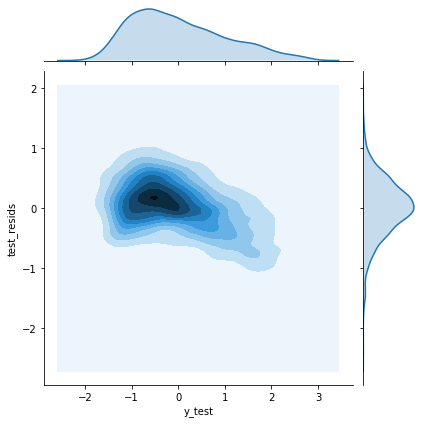

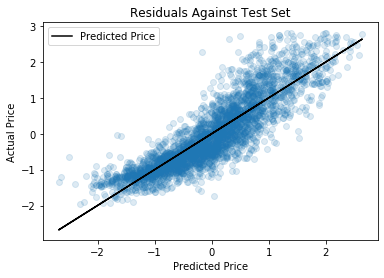

In [14]:
report(model1, X_train, X_test, 
       save_as = 'figures/Model1Resids.png')

Based on the MSE and R-squared, the model seems fairly accurate, with a few problems. Chiefly it seems to lack predictive value for highly priced homes. 

The floors variable lacks predictive influence. Information from the scatterplots during data exploration suggest that this is the result of the relationship being better modeled by polynomial regression.

The low difference between MSE of the test set and MSE against the training set indicates that this model is not overfit.

Finally, based on the KDE plot of residuals, it is clear that the model could be more generalizable, especially for high value homes. Interaction and polynomial features will likely improve predictive quality of the model. 

# Train the Model
In order to train the model and verify it's validity I will conduct the following steps:

1. Find and include interaction features.
2. Find and include polynomial features.
3. Filter variables for statistical significance.

## Find and Include Interaction Features

In [15]:
def plot_interaction(col1, col2):
    """
    Plot the regression lines of variables grouped by
    high and low values. Non-parellel lines show 
    interaction of variables.
    
    Parameters:
    col1: pandas Series. Variable to group by.
    col2: pandas Series. Variable to plot by
    """
    sample = X_train.join(y_train, how='outer')
    
    hisample = (sample.loc[sample[col1]
                           >sample[col1].quantile(.66)])
    midsample = (sample.loc[(sample[col1]
                             >=sample[col1].quantile(.33))
                            |(sample[col1]
                              <=sample[col1].quantile(.66))])
    losample = (sample.loc[sample[col1]
                           <sample[col1].quantile(.33)])
    
    fig, axes = plt.subplots(figsize=(6,3))
    sns.regplot(x=col2, y='price', data=hisample, 
                scatter=False, truncate=True,
                label='High Values of {}'.format(col1))
    sns.regplot(x=col2, y='price', data=midsample, 
                scatter=False, truncate=True,
                label='Middle Values of {}'.format(col1))
    sns.regplot(x=col2, y='price', data=losample, 
                scatter=False, 
                label='Low Values of {}'.format(col1))
    plt.title('Interaction of {} and {}'.format(col1, col2))
    plt.legend()
    plt.show();
    print('*********************\n')

In [16]:
def find_interactions(n, model, ind_train):
    """
    Returns n most predictive interactions based on low MSE.
    
    Parameters:
    n: int. the number of interactions selected.
    model: LinearRegression() object being tested. 
    ind_train: the independent variables in the training set.
    """
    combos = list(combinations(ind_train.columns, 2))
    print('Testing {} combinations.\n'.format(len(combos)))
    inters = [(0,0,0)]*n
    temp_X = ind_train.loc[:]
    for combo in combos:
        temp_X['interaction']=(ind_train.loc[:, combo[0]]
                               *ind_train.loc[:, combo[1]])
        linreg = LinearRegression()
        model = linreg.fit(temp_X, y_train)
        y_pred = model.predict(temp_X)
        score = round(r2_score(y_train, y_pred),3)
        if score > inters[-1][0]:
            inters.append((score, combo[0], combo[1]))
            inters = sorted(inters, reverse=True)[:n]
    for inter in inters:
        print('R^2 including interaction of {} and {}: {}'
              .format(inter[1], inter[2], inter[0]))
        plot_interaction(inter[1], inter[2])
    fin_inters = [i[1:] for i in inters]
    return fin_inters

Testing 210 combinations.

R^2 including interaction of lat and dist_to_Seattle: 0.77


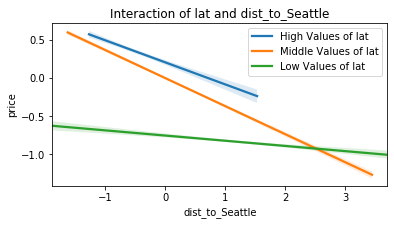

*********************

R^2 including interaction of grade and dist_to_Seattle: 0.763


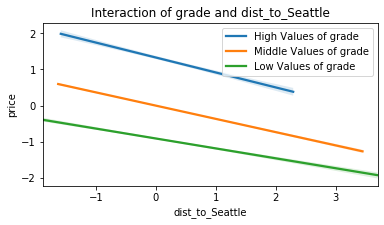

*********************

R^2 including interaction of lat and Seattle: 0.762


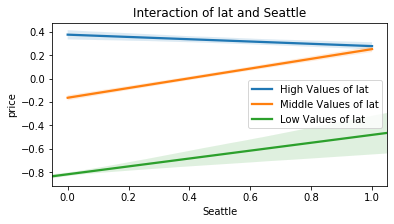

*********************

R^2 including interaction of sqft_living15 and dist_to_Seattle: 0.761


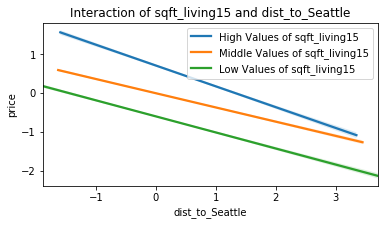

*********************

R^2 including interaction of sqft_living and dist_to_Seattle: 0.761


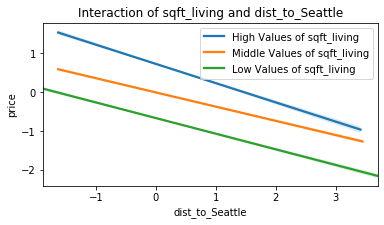

*********************

R^2 including interaction of long and Seattle: 0.76


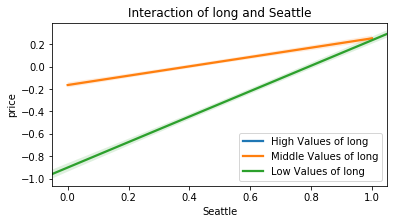

*********************

R^2 including interaction of lat and long: 0.757


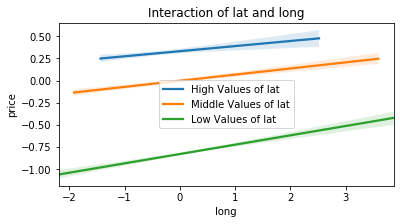

*********************

R^2 including interaction of sqft_living and lat: 0.756


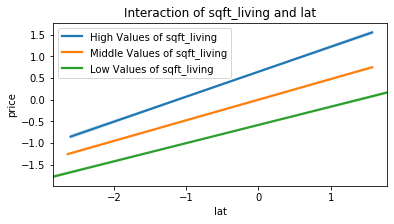

*********************

R^2 including interaction of lat and Bellevue: 0.756


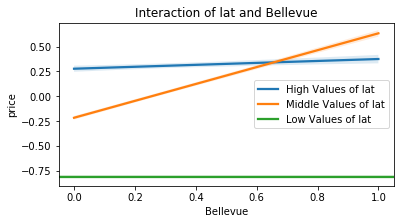

*********************

R^2 including interaction of grade and lat: 0.756


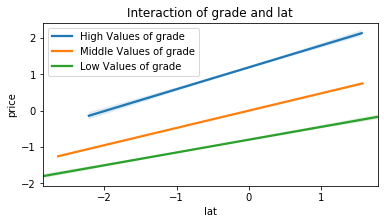

*********************

R^2 including interaction of grade and Seattle: 0.756


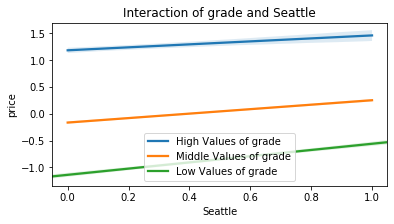

*********************

R^2 including interaction of grade and Kent: 0.756


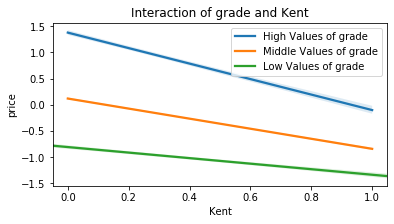

*********************

R^2 including interaction of sqft_living and Seattle: 0.755


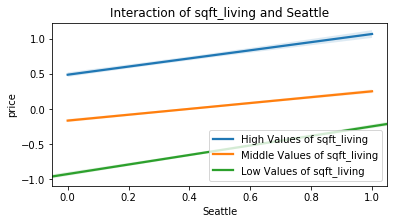

*********************

R^2 including interaction of sqft_living and Kent: 0.755


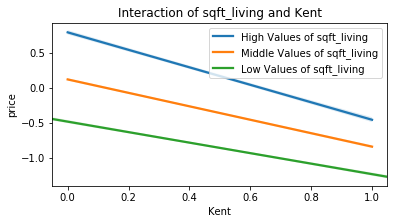

*********************

R^2 including interaction of long and dist_to_Seattle: 0.755


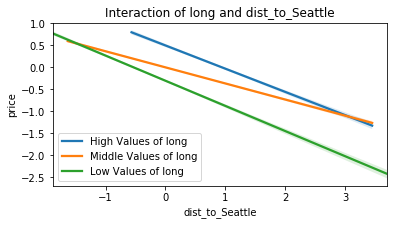

*********************



In [17]:
interactions = find_interactions(15, model1, X_train)

In [18]:
print('Homes south of Seattle: {}'
      .format(data[data['lat']<47.608013]['lat'].count()))
print('Distance of Farthest Southern home: {}'
      .format(47.608013-data['lat'].min()))
print('Distance of Farthest Nothern home: {}'
      .format(data['lat'].max()-47.608013))
data['lat'].describe()

Homes south of Seattle: 9386
Distance of Farthest Southern home: 0.4076129999999978
Distance of Farthest Nothern home: 0.16958699999999993


count    16261.000000
mean        47.561828
std          0.136957
min         47.200400
25%         47.477200
50%         47.570300
75%         47.681400
max         47.777600
Name: lat, dtype: float64

In [19]:
interactions

[('lat', 'dist_to_Seattle'),
 ('grade', 'dist_to_Seattle'),
 ('lat', 'Seattle'),
 ('sqft_living15', 'dist_to_Seattle'),
 ('sqft_living', 'dist_to_Seattle'),
 ('long', 'Seattle'),
 ('lat', 'long'),
 ('sqft_living', 'lat'),
 ('lat', 'Bellevue'),
 ('grade', 'lat'),
 ('grade', 'Seattle'),
 ('grade', 'Kent'),
 ('sqft_living', 'Seattle'),
 ('sqft_living', 'Kent'),
 ('long', 'dist_to_Seattle')]

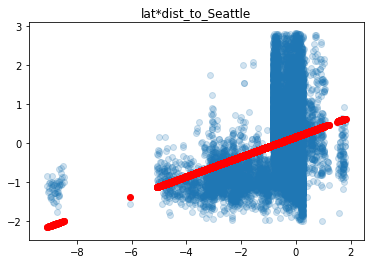

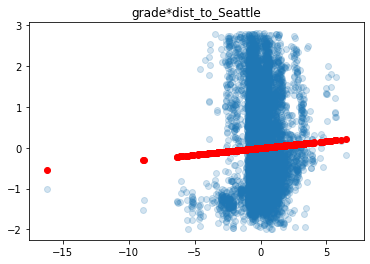

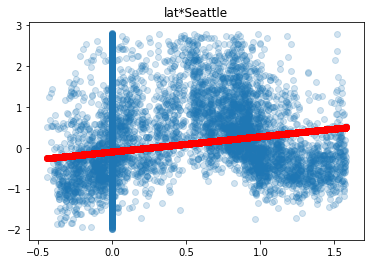

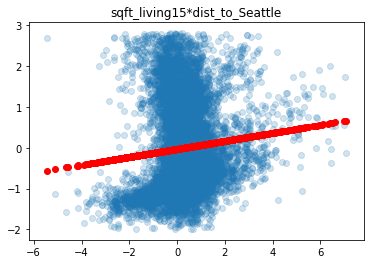

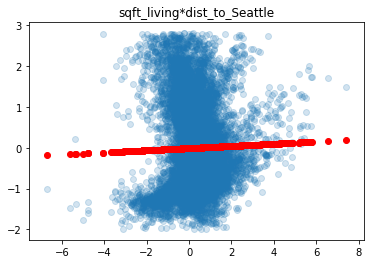

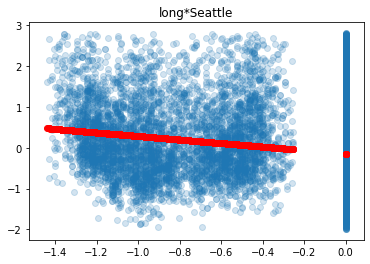

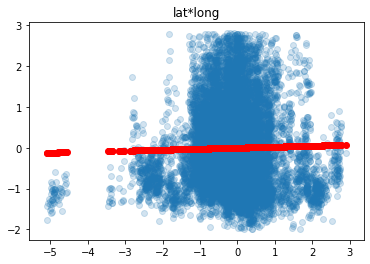

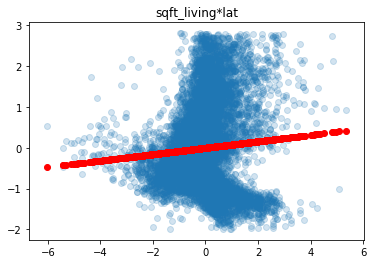

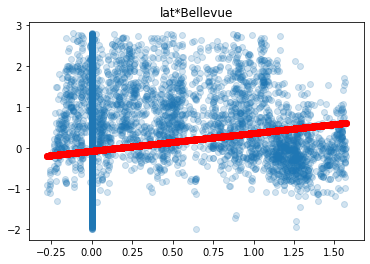

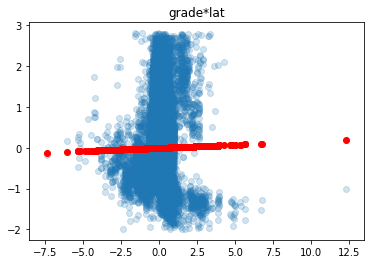

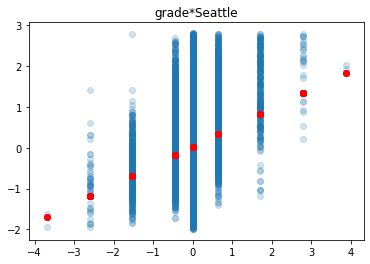

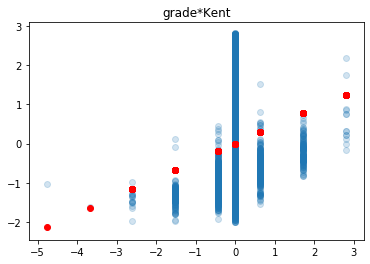

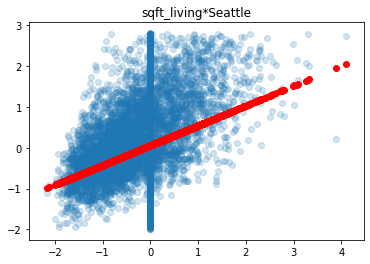

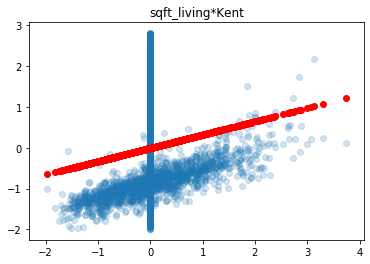

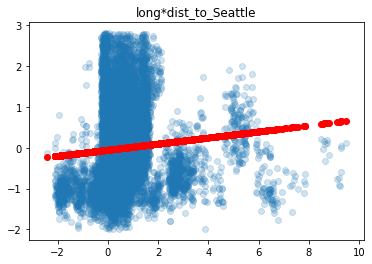

In [20]:
for inter in interactions:
    var = pd.DataFrame(X_train[inter[0]] * X_train[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    plt.scatter(var, y_train, alpha=.2)
    plt.scatter(var, y_pred, c='red')
    plt.title('{}*{}'.format(inter[0], inter[1]))
    plt.show()

These interactions illustrate an interesting phenomenon. Despite the general trends, each city seems to have different reactions to the values of the other variables. This is most clear in the chart evaluating the impact of latitude on Bellevue: whereas in most cases the price of a home increases the farther North it is, in Bellevue the trend is reversed. 

Because of this, I will include the following interactions:

- lat and dist_to_Seattle: houses in the middle latitudes drop in price more steeply than others as they gain distance from Seattle. This is likely the result of moving inland rather than north or south along the coast.

- lat and Seattle: houses in the Northernmost set of data lose value if they are in Seattle compared to Southernmost set of data. This indicates that home values are likely higher in southern Seattle than they are in the northern part of the city.

- long and Seattle: Houses farther to the West(the coastline) increase their value significantly more by being in Seattle than houses farther East.

- lat and Bellevue: Houses at the Southern side of Bellevue are more expensive than houses at the Northern side.

- sqft_living and Seattle: smaller houses increase in value more by being located in Seattle than larger houses.

- sqft_living and Kent: prices rise at a slower rate with increased square footage if in Kent.

- long and dist_to_Seattle: middle values of longitude decrease in price at a slower rate as they get farther from Seattle.

In [21]:
remove = [('grade', 'dist_to_Seattle'),
          ('sqft_living15', 'dist_to_Seattle'),
          ('sqft_living', 'dist_to_Seattle'),
          ('sqft_living', 'lat'),
          ('lat', 'long'), ('grade', 'lat'), 
          ('grade', 'Seattle'), ('grade', 'Kent')]
for inter in remove:
    interactions.remove(inter)

In [22]:
def add_interactions(interactions, ind_train, ind_test):
    """
    Use forward selection based on lowest MSE to select
    and add most predictive interactions to a new model.
    
    Parameters:
    interactions: list of tuples outputed by find_interaction
    function.
    ind_train: independent variables training data.
    ind_test: independent variables test data.
    
    Returns:
    (new_model, new_x_with_interactions)
    """
    additions = interactions
    X_temp_tr = ind_train.loc[:]
    X_best_tr = ind_train.loc[:]
    X_best_t = ind_test.loc[:]
    scores = []
    baseline = 0
    while additions:
        for inter in additions:
            X_temp_tr[inter[0]
                      +' * '
                      +inter[1]]=(X_temp_tr.loc[:, inter[0]]
                                  *X_temp_tr.loc[:, inter[1]])
            linreg = LinearRegression()
            model = linreg.fit(X_temp_tr, y_train)
            y_pred = model.predict(X_temp_tr)
            score = round(r2_score(y_train, y_pred),5)
            scores.append((score, inter[0], inter[1]))
            best = sorted(scores, reverse=True)[0]
            X_temp_tr = X_best_tr.loc[:]
        scores = []
        if best[0] >= baseline:
            additions.remove(best[1:])
            baseline = best[0]
            X_best_tr[best[1]
                      +' * '
                      +best[2]]=(X_temp_tr.loc[:, best[1]]
                                 * X_temp_tr
                                 .loc[:, best[2]])
            X_best_t[best[1]
                     +' * '
                     +best[2]]=(X_best_t.loc[:, best[1]]
                                *X_best_t.loc[:, best[2]])
            X[best[1]
              +' * '
              +best[2]]=(X.loc[:, best[1]]
                         *X.loc[:, best[2]])
            linreg = LinearRegression()
            model = linreg.fit(X_best_tr, y_train)
            y_pred = model.predict(X_best_tr)
            t_pred = model.predict(X_best_t)
            print('Interaction Added: {} * {}'
                  .format(best[1], best[2]))
            print('Current R^2: {}'
                  .format(best[0]))
            print('Current Test MSE: {}'
                  .format(round(mean_squared_error
                                (y_test, t_pred),5)))
            print('Current MSE Difference: {}\n'
                  .format(round(best[0]
                          -round(mean_squared_error
                                 (y_test, t_pred),5),5)))
        else:
            print('complete')
            break
    linreg = LinearRegression()
    new_model = linreg.fit(X_best_tr, y_train)
    return(new_model, X_best_tr, X_best_t)

In [23]:
model2, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train, X_test)

Interaction Added: lat * dist_to_Seattle
Current R^2: 0.77049
Current Test MSE: 0.21496
Current MSE Difference: 0.55553

Interaction Added: long * Seattle
Current R^2: 0.78313
Current Test MSE: 0.20148
Current MSE Difference: 0.58165

Interaction Added: lat * Bellevue
Current R^2: 0.79032
Current Test MSE: 0.19796
Current MSE Difference: 0.59236

Interaction Added: sqft_living * Seattle
Current R^2: 0.79531
Current Test MSE: 0.19055
Current MSE Difference: 0.60476

Interaction Added: sqft_living * Kent
Current R^2: 0.79839
Current Test MSE: 0.18725
Current MSE Difference: 0.61114

Interaction Added: long * dist_to_Seattle
Current R^2: 0.7984
Current Test MSE: 0.18724
Current MSE Difference: 0.61116

complete


************
High Impact Variables:

Variable: dist_to_Seattle
Coefficient: -0.8002220990098635

Variable: WaterFront
Coefficient: 1.2752942507376388

Variable: Federal Way
Coefficient: 0.5907835656652205

Variable: long * Seattle
Coefficient: -0.7100357075066617

************
************
Low Impact Variables:

Variable: rel_size
Coefficient: 0.00603830817545957

Variable: long * dist_to_Seattle
Coefficient: 0.004811856998647689

************

Train MSE: 0.2014744312186884
Test MSE: 0.18723983886010165
Difference:0.014234592358586762

Train R^2: 0.7983996197890716
CrossValidated R^2: 0.7974032392312127
Test R^2: 0.8131389828183642



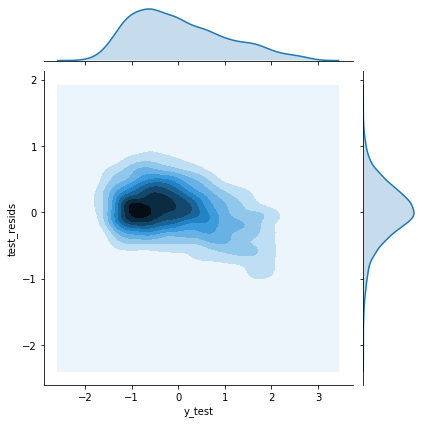

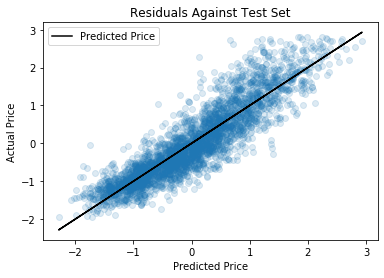

In [24]:
report(model2, X_train2, X_test2, 
       save_as = 'figures/Model2Resids.png')

## Find and include Polynomial Features
To find polynomial features I will iterate through the data, attempting to find data that suggests a polynomial relationship between price and the independent variable. I will then   

In [25]:
def get_polynomial_features(ind_train, 
                            max_degree = 3):
    features = []
    for col in ind_train.columns:
        scores = []
        for degree in range(1,max_degree + 1):
            df = pd.DataFrame(ind_train[col])
            poly = PolynomialFeatures(degree)
            X_poly_train = poly.fit_transform(df)
            reg_poly = LinearRegression().fit(X_poly_train,
                                              y_train)
            y_pred = reg_poly.predict(X_poly_train)
            score = round(mean_squared_error(y_train,
                                             y_pred),5)
            scores.append((score, degree, col, df, y_pred))
            best_score = sorted(scores)[0] 
        if best_score[1] > 1:
            print('Factor {} by {}. R^2: {}'
                  .format(best_score[2], 
                          best_score[1], best_score[0]))
            plt.scatter(best_score[3], y_train, alpha = .1)
            plt.scatter(best_score[3], best_score[4], 
                        c='red', label=('Predicted Values'))
            plt.legend()
            plt.show()
            features.append((best_score[2], best_score[1]))
    return features 

Factor bedrooms by 4. R^2: 0.92444


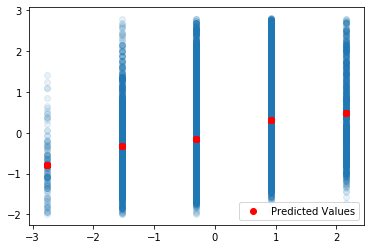

Factor bathrooms by 4. R^2: 0.84595


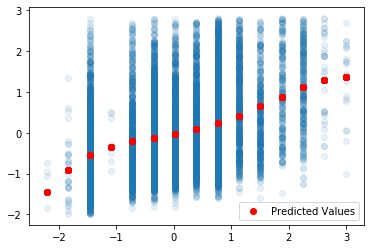

Factor sqft_living by 4. R^2: 0.68887


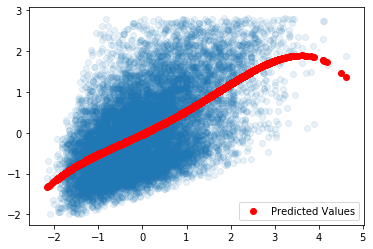

Factor floors by 4. R^2: 0.92532


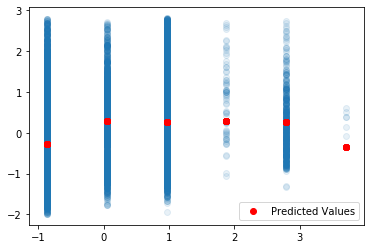

Factor view by 4. R^2: 0.95437


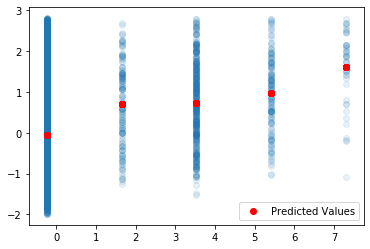

Factor grade by 4. R^2: 0.66949


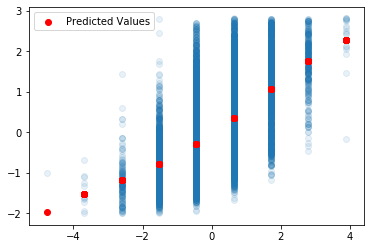

Factor sqft_basement by 4. R^2: 0.95101


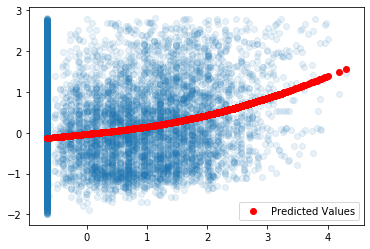

Factor lat by 4. R^2: 0.61434


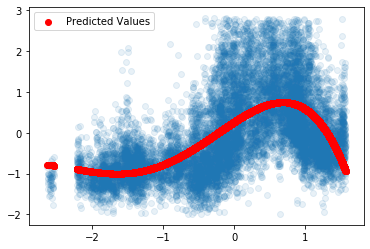

Factor long by 4. R^2: 0.96154


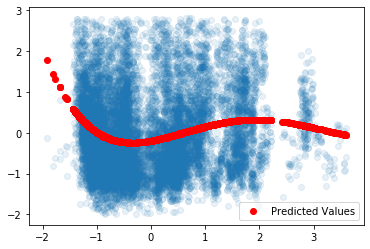

Factor sqft_living15 by 4. R^2: 0.74334


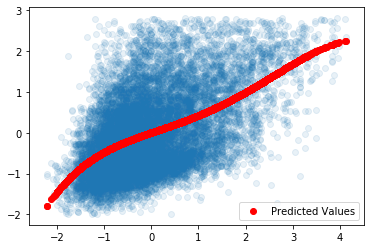

Factor month_sold by 3. R^2: 0.99529


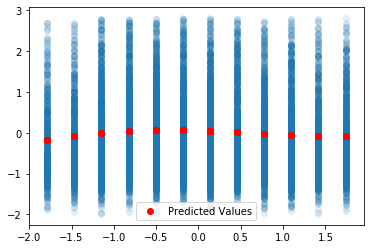

Factor age by 4. R^2: 0.94737


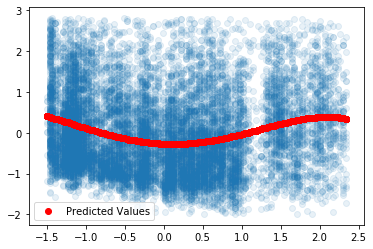

Factor dist_to_Seattle by 4. R^2: 0.85729


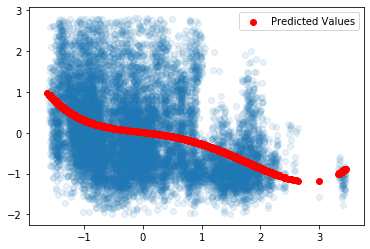

Factor rel_size by 4. R^2: 0.9498


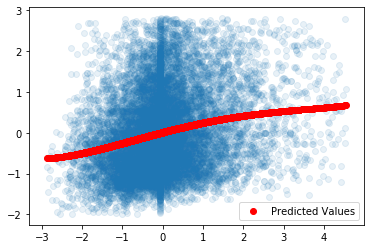

Factor lat * dist_to_Seattle by 4. R^2: 0.87506


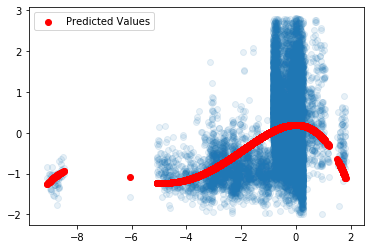

Factor long * Seattle by 4. R^2: 0.94251


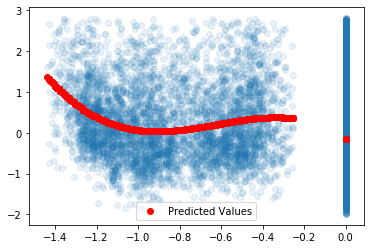

Factor lat * Bellevue by 4. R^2: 0.89566


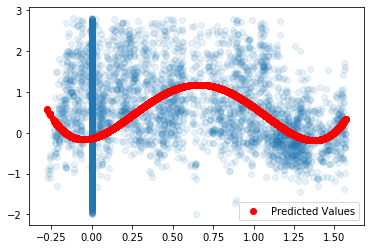

Factor sqft_living * Seattle by 4. R^2: 0.89731


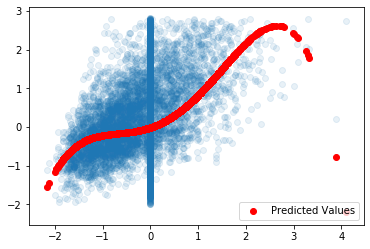

Factor sqft_living * Kent by 4. R^2: 0.94551


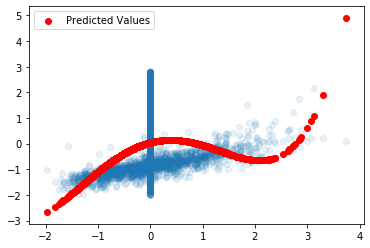

Factor long * dist_to_Seattle by 3. R^2: 0.94526


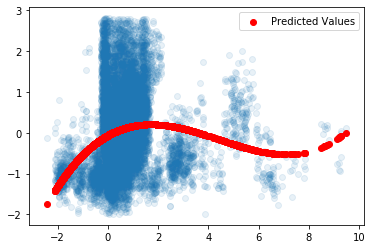

In [26]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 4)

In [27]:
poly_feat

[('bedrooms', 4),
 ('bathrooms', 4),
 ('sqft_living', 4),
 ('floors', 4),
 ('view', 4),
 ('grade', 4),
 ('sqft_basement', 4),
 ('lat', 4),
 ('long', 4),
 ('sqft_living15', 4),
 ('month_sold', 3),
 ('age', 4),
 ('dist_to_Seattle', 4),
 ('rel_size', 4),
 ('lat * dist_to_Seattle', 4),
 ('long * Seattle', 4),
 ('lat * Bellevue', 4),
 ('sqft_living * Seattle', 4),
 ('sqft_living * Kent', 4),
 ('long * dist_to_Seattle', 3)]

In [28]:
#Perform the same function as PolynomialFeatures, but name
# the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [29]:
linreg = LinearRegression()
model3 = linreg.fit(X_train3, y_train)

************
High Impact Variables:

Variable: lat
Coefficient: -9.909535588190545

Variable: long
Coefficient: 9.359869244254536

Variable: dist_to_Seattle
Coefficient: -22.70378496921058

Variable: Renton
Coefficient: -0.5032595311666632

Variable: long * Seattle
Coefficient: 7.2346344024581715

Variable: lat^2
Coefficient: 14.998267710754531

Variable: dist_to_Seattle^2
Coefficient: -5.675823094808639

Variable: long * Seattle^2
Coefficient: 10.430853906411814

Variable: long * Seattle^3
Coefficient: 5.923465841859668

Variable: lat * Bellevue^3
Coefficient: -1.8347620419570256

************
************
Low Impact Variables:

Variable: bedrooms^2
Coefficient: -0.004800893688364116

Variable: bedrooms^3
Coefficient: -0.00014248597726851386

Variable: bedrooms^4
Coefficient: -0.002135922874757945

Variable: bathrooms^3
Coefficient: 0.001456591469355173

Variable: bathrooms^4
Coefficient: -0.002166025062345811

Variable: sqft_living^3
Coefficient: -0.0032914050768189096

Variable: sqf

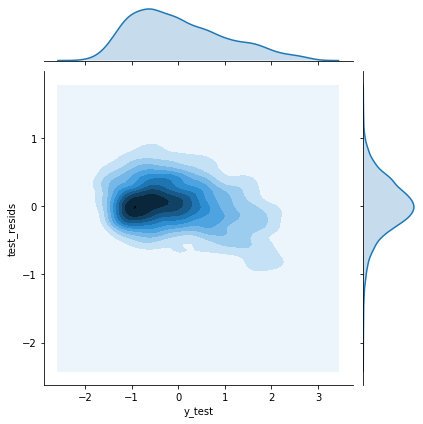

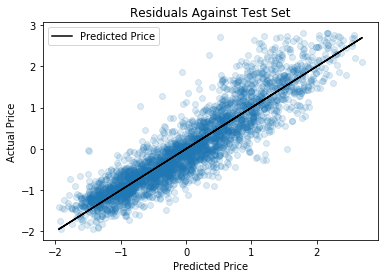

In [30]:
report(model3, X_train3, X_test3, 
       save_as='figures/Model3Resids.png')

## Filter by P-values

In [31]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with
        (column names of X)
        threshold_in - include a feature if its 
        p-value < threshold_in
        threshold_out - exclude a feature if its 
        p-value > threshold_out
        verbose - whether to print the sequence of 
        inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
         # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [32]:
results = stepwise_selection(X_train3, y_train)
X_train4 = X_train3.loc[:,results]
X_test4 = X_test3.loc[:,results]
X = X.loc[:,results]

C:\Users\Shawn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  Bellevue                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  lat^2                          with p-value 0.0
Add  Seattle                        with p-value 0.0
Add  sqft_living15^3                with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Drop sqft_living15^3                with p-value 0.821061
Add  sqft_living                    with p-value 0.0
Add  lat * dist_to_Seattle          with p-value 2.04441e-267
Drop bathrooms                      with p-value 0.988826
Add  lat                            with p-value 0.0
Add  grade                          with p-value 9.01538e-182
Add  age                            with p-value 1.17727e-217
Add  long^3                         with p-value 4.97466e-79
Add  view                           with p-value 8.14242e-78
Add  sqft_living * Seattle          with p-value 3.31596e-63
Add  Federal Way                    with p-value 1.4327e-40
Add  sqft_basement             

************
High Impact Variables:

Variable: Seattle
Coefficient: -0.3385807240125362

Variable: sqft_living
Coefficient: 0.41583407470370043

Variable: lat * dist_to_Seattle
Coefficient: -0.3500697123922749

Variable: dist_to_Seattle^2
Coefficient: 0.7977875396131503

Variable: long * dist_to_Seattle
Coefficient: -0.45945060150103345

Variable: WaterFront
Coefficient: 0.9975690352261061

************
************
Low Impact Variables:

Variable: lat * dist_to_Seattle^4
Coefficient: -0.0019328653202378976

Variable: bedrooms^4
Coefficient: -0.003259175493446834

Variable: sqft_living^3
Coefficient: -0.007273291149702744

Variable: view^4
Coefficient: 0.0004631187592836483

Variable: grade^3
Coefficient: -0.004009825883238918

************

Train MSE: 0.17601530987802705
Test MSE: 0.16794335820347459
Difference:0.008071951674552463

Train R^2: 0.8238746565521355
CrossValidated R^2: 0.8220983148562114
Test R^2: 0.8323964230376819



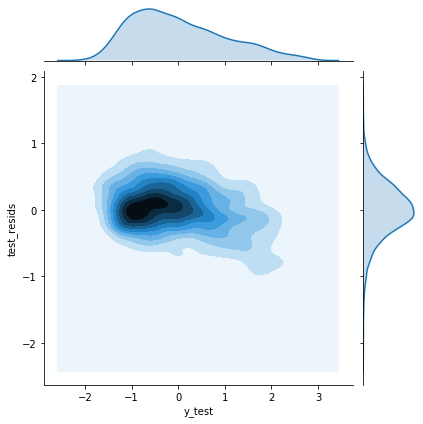

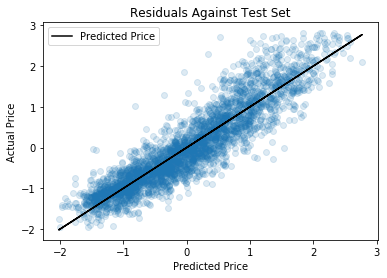

In [33]:
linreg = LinearRegression()
model4 = linreg.fit(X_train4, y_train)
report(model4, X_train4, X_test4, 
       save_as = 'figures/Model4Resids.png')

In [34]:
X_train4.to_csv('data/ind_vars_training.csv')
X_test4.to_csv('data/ind_vars_testing.csv')
y_train.to_csv('data/dep_var_training.csv', header=True)
y_test.to_csv('data/dep_var_testing.csv', header=True)
X.to_csv('data/independent_vars.csv')
y.to_csv('data/dependent_var.csv', header=True)